In [12]:
# Imports
import pandas as pd
import numpy as np


In [15]:
df = pd.read_csv("../data/2-intermediate/df_out_dsif2.csv")

In [14]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_status,debt_settlement_flag
0,167338079,4000.0,4000.0,4000.0,36,0.1308,134.93,B,B5,cashier,...,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,N,No Hardship,N
1,71016917,24000.0,24000.0,24000.0,60,0.0916,500.07,B,B2,ABM,...,60.0,0.0,0.0,88154.0,61815.0,13000.0,52954.0,N,No Hardship,N
2,39589826,5000.0,5000.0,5000.0,36,0.1049,162.49,B,B3,driver,...,33.3,0.0,1.0,171118.0,13124.0,10000.0,7526.0,N,No Hardship,N
3,134798709,24000.0,24000.0,24000.0,60,0.1105,522.42,B,B4,NaN,...,0.0,0.0,0.0,202606.0,18520.0,49000.0,20000.0,N,No Hardship,N
4,127097355,14000.0,14000.0,14000.0,60,0.1359,322.79,C,C2,Shipping Clerk,...,0.0,0.0,0.0,152081.0,34847.0,28800.0,38181.0,N,No Hardship,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 110 entries, id to debt_settlement_flag
dtypes: float64(84), int64(2), object(24)
memory usage: 83.9+ MB


## 1. Extra Cleaning Step after EDA

In [16]:
# Drop the columns that are essentially data leakage
df = df.drop(columns=['recoveries', 'collection_recovery_fee', 'debt_settlement_flag'])

# Drop the columns that are not useful for our model
df = df.drop(columns=['id', 'url', 'title', 'zip_code', 'addr_state', 'emp_title', 'issue_d', 'initial_list_status', 'hardship_flag', 'sub_grade', 'next_pymnt_d', 'last_credit_pull_d', 'pymnt_plan'])

In [17]:
# Drop rows with missisng values in more than 20 columns
df.dropna(thresh=df.shape[1] - 20, inplace=True)

In [18]:
# clean the emp_length column by extracting the number and if null, keep it null
df['emp_length'] = df['emp_length'].replace('< 1 year', '0')
df['emp_length_num'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length_num'] = pd.to_numeric(df['emp_length_num'], errors='coerce')
df.drop(columns=['emp_length'], inplace=True)

# revol_util is a percentage, so we need to remove the % sign and convert to float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float) / 100

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\U-ser\AppData\Local\Temp\ipykernel_36464\168676372.py:3: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length_num'] = df['emp_length'].str.extract('(\d+)').astype(float)


## 2. Feature Engineering

In [ ]:
# Convert earliest credit line, last_pymnt_d to an integer (number of days from now to the earliest credit line)
from datetime import datetime
# 1. Convert Month-Year strings to proper datetime objects
df['earliest_cr_line'] = pd.to_datetime(
    df['earliest_cr_line'], 
    format='%b-%Y',    # Month as abbreviated name (e.g. Dec), then 4-digit Year
    errors='coerce'    # invalid formats become Nan (missing)
)

# 2. Calculate days from today
today = datetime.today()
df['earliest_cr_line_days'] = (today - df['earliest_cr_line']).dt.days
df.drop(columns=['earliest_cr_line'], inplace=True)


# Convert last_pymnt_d to an integer (number of days from now to the last payment date)
df['last_pymnt_d'] = pd.to_datetime(
    df['last_pymnt_d'], 
    format='%b-%Y',    # Month as abbreviated name (e.g. Dec), then 4-digit Year
    errors='coerce'    # invalid formats become Nan (missing)
)

# 2. Calculate days from today
today = datetime.today()
df['last_pymnt_d_days'] = (today - df['last_pymnt_d']).dt.days
df.drop(columns=['last_pymnt_d'], inplace=True)

In [20]:
# Loan Status Binary Encoding
# Fully Paid = 0
# Charged Off = 1
values_to_map = {'Fully Paid': 0, 'Current': 0, 'Issued': 0, 'In Grace Period': 0, 'Late (16-30 days)': 0, 'Late (31-120 days)': 1, 'Charged Off': 1, 'Default': 1}

df['loan_default'] = df['loan_status'].map(values_to_map)
df.drop(columns=['loan_status'], inplace=True)


In [21]:
# Log transform the skewed columns
columns_log = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
                'mths_since_last_delinq', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                'last_pymnt_amnt','acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'earliest_cr_line_days',
                'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op',
                'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
                'num_sats', 'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_util']

df_log = df.copy()
for col in columns_log:
    if col in df_log.columns:
        if df_log[col].notnull().sum() == 0:
            print(f"[SKIPPED] {col}: all values are NaN")
            continue
        
        # Skip if all values are <= 0 (log1p would error)
        if (df_log[col].dropna() <= 0).all():
            print(f"[SKIPPED] {col}: all values are zero or negative")
            continue
        
        # Apply log1p safely (preserve NaN)
        df_log[col] = df_log[col].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else x)
    else:
        print(f"[WARNING] Column '{col}' not found in DataFrame.")

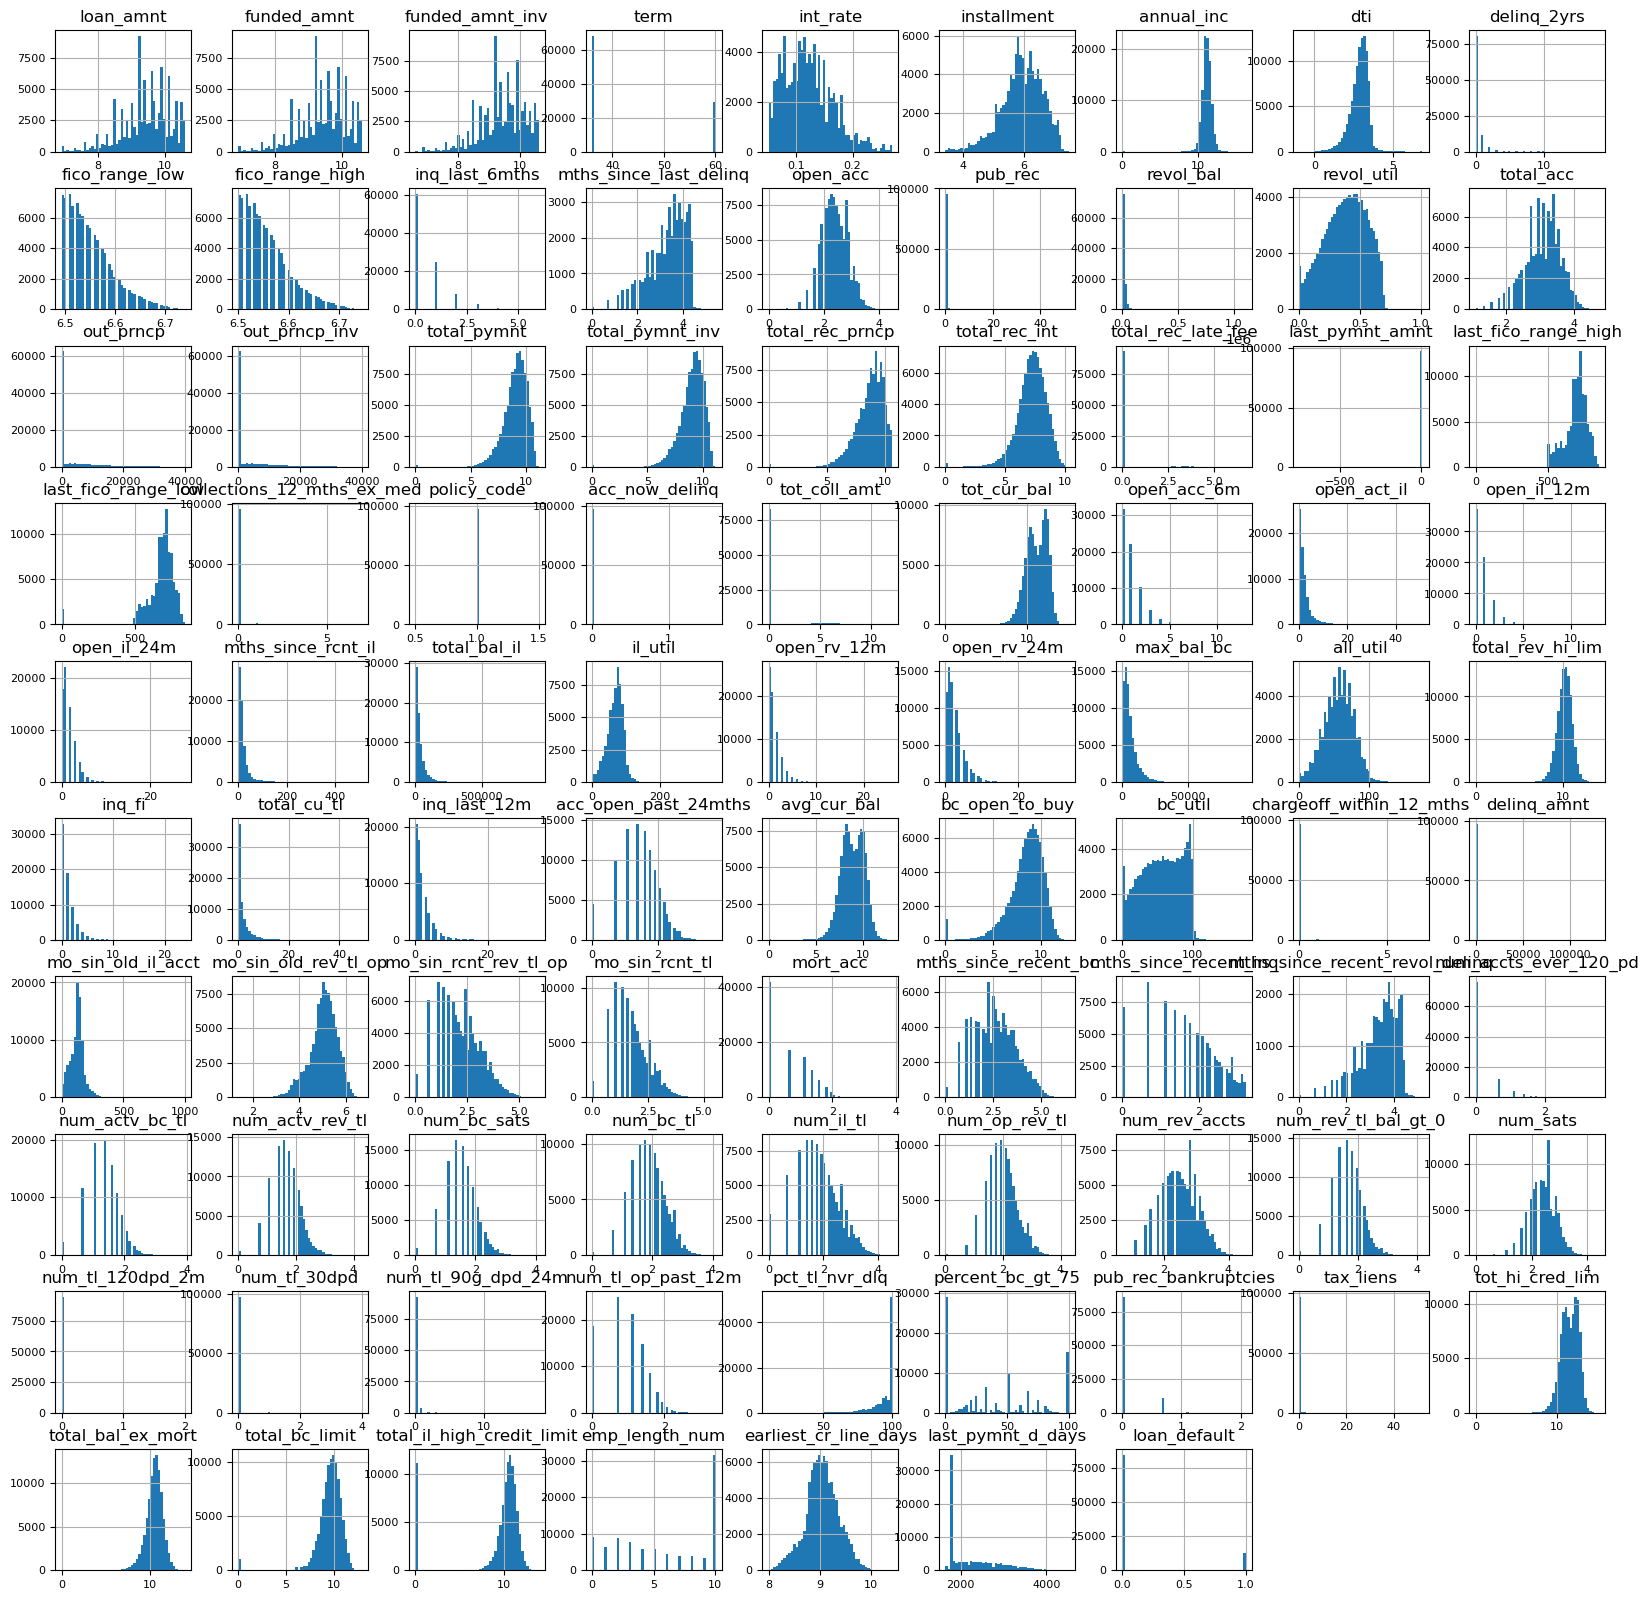

In [33]:
df_log.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

### 2.1 Engineering for Tree-Based Algorithm

In [22]:
# Print the object columns
object_columns = df_log.select_dtypes(include=['object']).columns
object_columns

Index(['grade', 'home_ownership', 'verification_status', 'purpose',
       'application_type', 'hardship_status'],
      dtype='object')

In [24]:
# For missing values, since we are going to use XGBoost, we can use the default behavior of XGBoost to handle missing values. 
df_log_tree = df_log.copy()

# For categorical columns, we can use one-hot encoding.
columns_encode  = ['grade', 'home_ownership', 'verification_status', 'purpose', 'application_type', 'hardship_status']
df_log_tree = pd.get_dummies(df_log_tree, columns=columns_encode, drop_first=True)

### 2.2 Engineering for Neural Networks (Challenger Model)

In [28]:
# Print null values by column
null_counts = df_log.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)


mths_since_recent_revol_delinq    66057
mths_since_last_delinq            51228
il_util                           37228
mths_since_rcnt_il                29316
all_util                          27200
inq_last_12m                      27187
total_cu_tl                       27187
open_rv_24m                       27187
open_rv_12m                       27187
inq_fi                            27187
total_bal_il                      27187
open_il_24m                       27187
open_il_12m                       27187
open_act_il                       27187
open_acc_6m                       27187
max_bal_bc                        27187
mths_since_recent_inq             10925
emp_length_num                     6885
num_tl_120dpd_2m                   3074
mo_sin_old_il_acct                 2931
bc_util                            1097
percent_bc_gt_75                   1066
bc_open_to_buy                     1047
mths_since_recent_bc                988
last_pymnt_d_days                   188


In [27]:
# For Nan values in "month_since...." columns, we Impute + Missing Indicator
from sklearn.impute import SimpleImputer

null_counts = df_log.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0].index.tolist()
df_log_nn = df_log.copy()

# 3. Impute + add missing indicators
for col in columns_with_nulls:
    # Skip dti
    if col == 'dti':
        print(f"[SKIPPED] {col}: handled separately")
        continue

    # Skip non-numeric columns
    if not np.issubdtype(df_log_nn[col].dtype, np.number):
        print(f"[SKIPPED] {col}: non-numeric column")
        continue

    # Add missing indicator column (1 = missing, 0 = present)
    df_log_nn[col + "_NA"] = df_log_nn[col].isnull().astype(int)

    # Impute missing values with median (safely, avoiding chained assignment)
    median_value = df_log_nn[col].median()
    df_log_nn[col] = df_log_nn[col].fillna(median_value)

    print(f"[IMPUTED] {col}: median={median_value}, indicator={col + '_NA'} added")

[SKIPPED] dti: handled separately
[IMPUTED] mths_since_last_delinq: median=3.4965075614664802, indicator=mths_since_last_delinq_NA added
[IMPUTED] revol_util: median=0.39406706315579504, indicator=revol_util_NA added
[IMPUTED] open_acc_6m: median=1.0, indicator=open_acc_6m_NA added
[IMPUTED] open_act_il: median=2.0, indicator=open_act_il_NA added
[IMPUTED] open_il_12m: median=0.0, indicator=open_il_12m_NA added
[IMPUTED] open_il_24m: median=1.0, indicator=open_il_24m_NA added
[IMPUTED] mths_since_rcnt_il: median=13.0, indicator=mths_since_rcnt_il_NA added
[IMPUTED] total_bal_il: median=24095.5, indicator=total_bal_il_NA added
[IMPUTED] il_util: median=72.0, indicator=il_util_NA added
[IMPUTED] open_rv_12m: median=1.0, indicator=open_rv_12m_NA added
[IMPUTED] open_rv_24m: median=2.0, indicator=open_rv_24m_NA added
[IMPUTED] max_bal_bc: median=4569.0, indicator=max_bal_bc_NA added
[IMPUTED] all_util: median=57.0, indicator=all_util_NA added
[IMPUTED] inq_fi: median=1.0, indicator=inq_fi_

In [30]:
## Deal with missing values in 'annual_inc' and 'dti'
# Create 'no_income' indicator
df_log_nn['no_income'] = ((df_log_nn['annual_inc'].isnull()) | (df_log_nn['annual_inc'] == 0)).astype(int)

# Identify where dti is null but annual_inc is 0 or missing
dti_null_and_no_income = df_log_nn['dti'].isnull() & (df_log_nn['annual_inc'].isnull() | (df_log_nn['annual_inc'] == 0))

print(f"[INFO] Rows where dti is NaN due to no income: {dti_null_and_no_income.sum()}")

# Median impute dti
dti_median = df_log_nn['dti'].median()
df_log_nn['dti'] = df_log_nn['dti'].fillna(dti_median )

# Add missing indicator column (even if imputed) — general practice for NNs
df_log_nn['dti_NA'] = df_log['dti'].isnull().astype(int)

[INFO] Rows where dti is NaN due to no income: 99


In [ ]:
# No more null values, check!
null_counts = df_log_nn.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [34]:
# Print the object columns
object_cols = df_log_nn.select_dtypes(include=['object', 'category']).columns.tolist()
object_cols

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'hardship_status']

In [35]:
# For categorical columns, we implement an embedding. 
from sklearn.preprocessing import LabelEncoder

# Store the encoders if you want to use them later (e.g., in production inference)
label_encoders = {}
for col in object_cols:
    le = LabelEncoder()
    df_log_nn[col] = df_log_nn[col].astype(str).fillna("missing")  # convert to str and handle NaN
    df_log_nn[col] = le.fit_transform(df_log_nn[col])
    label_encoders[col] = le


In [36]:
df_log_nn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97543 entries, 0 to 99999
Columns: 124 entries, loan_amnt to dti_NA
dtypes: float64(86), int32(36), int64(2)
memory usage: 79.6 MB


## Saving and Exporting Data

In [37]:
df_log_tree.to_csv("../data/2-intermediate/df_out_dsif3_tree.csv"
                        , index = False)

df_log_nn.to_csv("../data/2-intermediate/df_out_dsif3_nn.csv"
                        , index = False)